# Project specification


## 1) Calibration (camera matrix, distortion coefficients)

## Pipeline
* 2) Color transform, Gradients -> thresholded binary image
* 3) Perspective transform
* 4) Identification of lane line pixels
* 5) Radius of curvature calculation
* 6) Lane area plotted back down onto the road

* (7) Lane history + smoothing)

# Imported modules

# 1) Calibration


Theory

### todo: _intrinsic or extrinsic?!_ -> distortion correction

"For better results, we need atleast 10 test patterns."
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

"Now for X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... which denotes the location of points. In this case, the results we get will be in the scale of size of chess board square." https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

...

---

* a) Prepare object points for chessboard corners
* b) Find chessboard corners in all images
* c) Calibrate camera (distortion correction) https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html
* d) get perspective transform

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from help_func import plot, draw_lines_from_points
import pickle
# for interactive plots
#%matplotlib notebook
%matplotlib inline


### moved to calibration.ipynb

In [5]:
# # initialize array for object points with dimensions (6*9, 3)
# objp = np.zeros((6*9,3), np.float32)
# # create mesh grid, transpose and reshape to get an (6*9, 2) array 
# # for all object points (z component is assumed to be 0)
# objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# # initialize arrays for object- and image points from all
# # calibration images
# objpts = [] # 3D points in real world space
# imgpts = [] # 2D points in image plane

### moved to calibration.ipynb

In [6]:
# # get list of all available calibration images
# cal_images = glob.glob('camera_cal/calibration*.jpg')

### moved to calibration.ipynb

In [7]:
# # find chessboard corners in all images
# for idx, img_name in enumerate(cal_images):
#     img = cv2.imread(img_name) # read image
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    
#     # find chessboard corners
#     ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
#     # if corners were found, object- and image points are added
#     if ret == True:
#         objpts.append(objp)
#         imgpts.append(corners)

#         # draw and display/save corners
# #         cv2.drawChessboardCorners(img, (9,6), corners, ret)        
# #         folder_name = 'output_images/'
# #        # file_name = 'chessboard_corners_'+img_name[11:]
# #        # cv2.imwrite(folder_name+file_name, img)
#         # cv2.imshow('img', img)
#         # cv2.waitKey(500)

idea for calibration function:
https://github.com/mithi/advanced-lane-detection

In [8]:
### todo: class and functions descriptions
class Calibration:
    
    def __init__(self, cam_mtx, dist_coeff, src_pts, dst_pts):
        self.cam_mtx = cam_mtx
        self.dist_coeff = dist_coeff
        self.src_pts = src_pts
        self.dst_pts = dst_pts
        self.warp_mtx = cv2.get_PerspectiveTransform(scr_pts, dst_pts)
        
    def undistort(self, dist_img):
        undist_img = cv2.undistort(dist_img, self.cam_mtx, 
                                   self.dist_coeff, None, 
                                   self.cam_mtx)
        return undist_img
    
    def warp(self, img):
        img_size = (img.shape[1], img.shape[0])
        warped_img = cv2.warpPerspective(img, self.warp_mtx, 
                                         img_size, 
                                         flags = cv2.INTER_LINEAR)
        return warped_img

### moved to calibration.ipynb

In [9]:
# # load distorted image and get size
# dist_img = cv2.imread('camera_cal/calibration2.jpg')
# img_size = (img.shape[1], img.shape[0])

# # calibrate camera (returns the camera matrix, distortion coefficients, rotation and translation vectors)
# ret, mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None ,None)

# calib = Calibration(mtx, dist_coeff, src_pts, dst_pts)

# undist_img = calib.undistort(dist_img)

# # undistort example image
# # undist = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()

# ax1.imshow(dist_img)
# ax2.imshow(undist_img)

# # plt.imshow(undist_img)
# # cv2.imwrite('output_images/calibration2_undistorted.jpg', undist)

In [10]:
pickled_data = pickle.load(open("pickled_calib_data.p", "rb"))
mtx = pickled_data["mtx"]
dist_coeff = pickled_data["dist_coeff"]
warp_mtx = pickled_data["warp_mtx"]

---

# Pipeline

## Create binary image

### gradient (function sobel_thresh)

>"In our last example, output datatype is cv2.CV_8U or np.uint8. But there is a slight problem with that. Black-to-White transition is taken as Positive slope (it has a positive value) while White-to-Black transition is taken as a Negative slope (It has negative value). So when you convert data to np.uint8, all negative slopes are made zero. In simple words, you miss that edge.

>If you want to detect both edges, better option is to keep the output datatype to some higher forms, like cv2.CV_16S, cv2.CV_64F etc, take its absolute value and then convert back to cv2.CV_8U. Below code demonstrates this procedure for a horizontal Sobel filter and difference in results."

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html

In [11]:
def grad_thresh(img, orient='x', 
                kernel = 3, thresh=(0, 255)):
    """Creates thresholded binary image based on directional 
    gradient"""
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     import pdb; pdb.set_trace()
    # take derivative in 'orient' direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    else:
        print('only x and y are accepted as 2nd argument')
        return None
    # calculate absolute value and scale to 8-bit
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    # create binary image
    grad_bin = np.zeros_like(scaled_sobel)
    grad_bin[(scaled_sobel >= thresh[0]) & 
                (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_bin

In [12]:
def grad_mag_thresh(img, kernel = 3, thresh = (0, 255)):
    # convert to grayscale    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # apply sobel in both x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate magnitude
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # scale to 8-bit and convert to type uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # create binary magnitude image
    grad_mag_bin = np.zeros_like(scaled_sobel)
    grad_mag_bin[(scaled_sobel >= thresh[0]) & 
            (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_mag_bin

In [13]:
def grad_dir_thresh(image, kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # apply sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate absolute values of sobelx and sobely
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # calculate gradient direction
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # apply threshold
    grad_dir_bin = np.zeros_like(gray)
    grad_dir_bin[(grad_dir >= thresh[0]) & 
            (grad_dir <= thresh[1])] = 1
    
    return grad_dir_bin

# use one example image

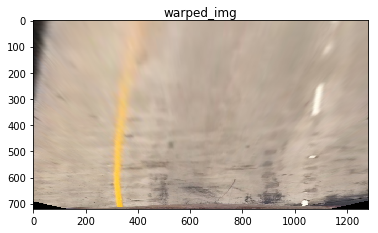

In [14]:
# read image and get size
# src_img = mpimg.imread('test_images/straight_lines1.jpg')
src_img = mpimg.imread('test_images/test1.jpg')
img_size = (src_img.shape[1], src_img.shape[0])

# undistort and warp
undist_img = cv2.undistort(src_img, mtx, dist_coeff)
warped_img = cv2.warpPerspective(undist_img, warp_mtx, img_size, 
                   flags = cv2.INTER_LINEAR)
plt.imshow(warped_img)
plt.title('warped_img')

# gradient threshold

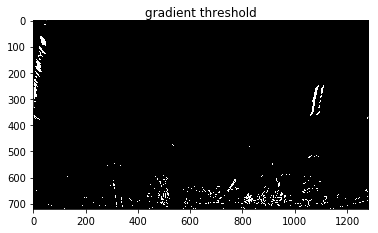

In [15]:
grad_bin_img = grad_thresh(warped_img, 'x', 
                          kernel = 3, thresh = (20, 80))
plt.imshow(grad_bin_img, cmap = 'gray')
plt.title('gradient threshold')

# magnitude threshold

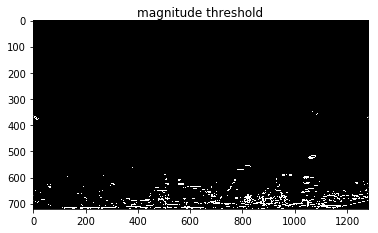

In [16]:
grad_mag_bin_img = grad_mag_thresh(warped_img, kernel = 3, thresh = (20, 100))
plt.imshow(grad_mag_bin_img, cmap = 'gray')
plt.title('magnitude threshold')

# gradient direction threshold

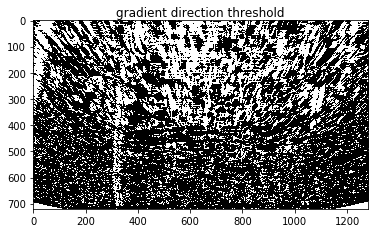

In [17]:
grad_dir_bin_img = grad_dir_thresh(warped_img, 
                         kernel = 7, thresh = (0, 0.5))
plt.imshow(grad_dir_bin_img, cmap = 'gray')
plt.title('gradient direction threshold')

In [18]:
def color_s_thresh(img, thresh = (0, 255)):
    # convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    color_s_bin = np.zeros_like(hls[:,:,2])
    color_s_bin[(hls[:,:,2] > thresh[0]) & 
                  (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return color_s_bin

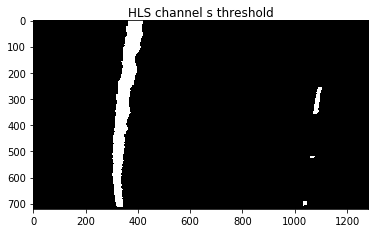

In [19]:
# threshold 120, 255 works well!
color_bin_img = color_s_thresh(warped_img, thresh = (120, 255))
plt.imshow(color_bin_img, cmap = 'gray')
plt.title('HLS channel s threshold')


# histogram

In [20]:
def hist(img):
    # only include lower half of the image
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis = 0)
    
    return histogram

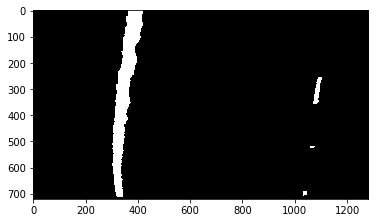

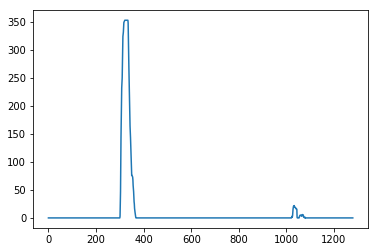

In [21]:
# normalize image from 0-255 to 0-1

# gray = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)

# normalized_img = gray/255


histogram = hist(color_bin_img)

plt.figure()
plt.imshow(color_bin_img, cmap = 'gray')
plt.figure()
plt.plot(histogram)

# sliding window

In [37]:
# different name like "sliding_window?"
# maybe change argument name to binary_warped or similar
def find_lane_pixels(img):
    histogram = hist(img)
    out_img = np.dstack((img, img, img))
    # find midpoint, left and right peak
    mid_pnt = np.int(histogram.shape[0]//2)
    left_x_start = np.argmax(histogram[:mid_pnt])
    right_x_start = np.argmax(histogram[mid_pnt:]) + mid_pnt
    
    # hyperparameters
    # number of sliding windows:
    n_win = 9
    # width of windows (+/-margin)
    margin = 100
    # min number of pixels to recenter window
    min_pix = 50
    
    # windows height
    win_h = np.int(img.shape[0]//n_win)
    # find s and y positions of all nonzero pixels
    nonzero = img.nonzero()
    nonzero_x = np.array(nonzero[0])
    nonzero_y = np.array(nonzero[1])
    
    # initialize current positions with start positions from histogram
    left_x_current = left_x_start
    right_x_current = right_x_start
    
    # initialization of lists for lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # loop through all windows
    for win in range(n_win):
        # determine window y boundaries
        win_y_low = img.shape[0] - (win+1)*win_h
        win_y_high = img.shape[0] - win*win_h
        # determine window x boundaries
        win_xleft_low = left_x_current - margin
        win_xleft_high = left_x_current + margin
        win_xright_low = right_x_current - margin
        win_xright_high = right_x_current + margin
        
        # draw windows
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        # find nonzero pixels in x and y within current window
        good_left_inds = np.where(((nonzero_y >= win_y_low) & 
                                   (nonzero_y < win_y_high)) & 
                                  ((nonzero_x >= win_xleft_low) & 
                                   (nonzero_x < win_xleft_high)))[0]
        good_right_inds = np.where(((nonzero_y >= win_y_low) & 
                                    (nonzero_y < win_y_high) & 
                                  (nonzero_x >= win_xright_low) & 
                                    (nonzero_x < win_xright_high)))[0]
        
        # append the indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if pixels in window > minpix pixels, recenter next window
        # on their mean position
        if np.count_nonzero(good_left_inds) > min_pix:
            leftx_current = np.uint16(np.mean(nonzerox[good_left_inds]))
        if np.count_nonzero(good_right_inds) > min_pix:
            rightx_current = np.uint16(np.mean(nonzerox[good_right_inds]))
    
        # concatenate the arrays of indices 
        # (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
            
        # Extract left and right line pixel positions
        leftx = nonzero_x[left_lane_inds]
        lefty = nonzero_y[left_lane_inds] 
        rightx = nonzero_x[right_lane_inds]
        righty = nonzero_y[right_lane_inds]
        
        return leftx, lefty, rightx, righty, out_img

In [38]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(color_bin_img)


# use of calib class

In [ ]:
# unwarped_img = np.copy(undist_img)
raw_img = mpimg.imread('test_images/test6.jpg')
undist_img = calib.undistort(raw_img)
# raw_img = mpimg.imread('test_images/test1.jpg')
# undist_img = calib.undistort(raw_img)

warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped_img = cv2.warpPerspective(undist_img, warp_mtx, 
                                 img_size, flags=cv2.INTER_LINEAR)

plt.figure()
plt.imshow(undist_img)
line_img1 = draw_lines_from_points(undist_img, src_pts)
plt.figure()
plt.imshow(undist_img)

plt.figure()
plt.imshow(warped_img)
line_img2 = draw_lines_from_points(warped_img, dst_pts)
plt.figure()
plt.imshow(warped_img)


In [ ]:
def pipeline(src_img):
    # undistort image    
    
    undist_img = calib.undistort(src_img)
#     plot_func(img); plot_func(undist)

#     warped_img = calib.warp(undist)
    warp_mtx = cv2.getPerspectiveTransform(src_pts, )

    plot(undist_img)
    plot(warped_img)
    
    #     grad_thresh(undist)

In [ ]:
img = mpimg.imread('test_images/straight_lines1.jpg')

pipeline(img)